In [2]:
import time
import joblib
import numpy as np
from pathlib import Path

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from utils import load_data, split_data

In [3]:
# ---------------------------------------
# Load Processed Data using utils
# ---------------------------------------

df = load_data("pdf_featured_processed_dataset.csv")

X_train, X_test, y_train, y_test = split_data(df, target_column="label")

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

Training shape: (582, 11)
Testing shape: (146, 11)


In [4]:
# ---------------------------------------
# Model Definition (Random Forest)
# ---------------------------------------

model = RandomForestClassifier(random_state=42)

param_grid = {
    "n_estimators": [100],      
    "max_depth": [6, 8, 10],             # Pushing depth even lower
    "min_samples_split": [20, 30, 50],   # Forcing much larger groups before splitting
    "min_samples_leaf": [10, 15, 20]     # Forcing larger final prediction buckets
}

kfold = KFold(n_splits=3, shuffle=True, random_state=42)  # reduced from 5 to 3 folds

grid = RandomizedSearchCV(                                  # switched from GridSearchCV
    model,
    param_grid,
    n_iter=20,
    cv=kfold,
    scoring="r2",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [5]:
# ---------------------------------------
# Train Model (with timing)
# ---------------------------------------

print("\nStarting hyperparameter search...")
start = time.time()

grid.fit(X_train, y_train)

search_time = time.time() - start
print(f"\nHyperparameter Search Time: {search_time:.2f} seconds")

print("Best Parameters:", grid.best_params_)
print("Best CV R2:", grid.best_score_)

# Retrain best model with 300 estimators for better accuracy
print("\nRetraining best model with 300 estimators...")
retrain_start = time.time()

best_params = grid.best_params_.copy()
best_params["n_estimators"] = 300

best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

retrain_time = time.time() - retrain_start
total_time = search_time + retrain_time

print(f"Retraining Time:            {retrain_time:.2f} seconds")
print(f"Total Training Time:        {total_time:.2f} seconds")


Starting hyperparameter search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/ocs-22/Documents/pdf-structure-analyze-model/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ocs-22/Documents/pdf-structure-analyze-model/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/ocs-22/Documents/pdf-structure-analyze-model/venv/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/ocs-22/Documents/pdf-structure-analyze-model/venv/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/ocs-22/Documents/pdf-structure-analyze-m


Hyperparameter Search Time: 10.29 seconds
Best Parameters: {'n_estimators': 100, 'min_samples_split': 50, 'min_samples_leaf': 20, 'max_depth': 6}
Best CV R2: nan

Retraining best model with 300 estimators...
Retraining Time:            0.66 seconds
Total Training Time:        10.95 seconds



---------------------------------------
        FINAL TEST PERFORMANCE
---------------------------------------
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

      Footer       1.00      1.00      1.00         7
       Image       1.00      1.00      1.00        31
   Paragraph       1.00      1.00      1.00        85
  Subheading       1.00      1.00      1.00        23

    accuracy                           1.00       146
   macro avg       1.00      1.00      1.00       146
weighted avg       1.00      1.00      1.00       146



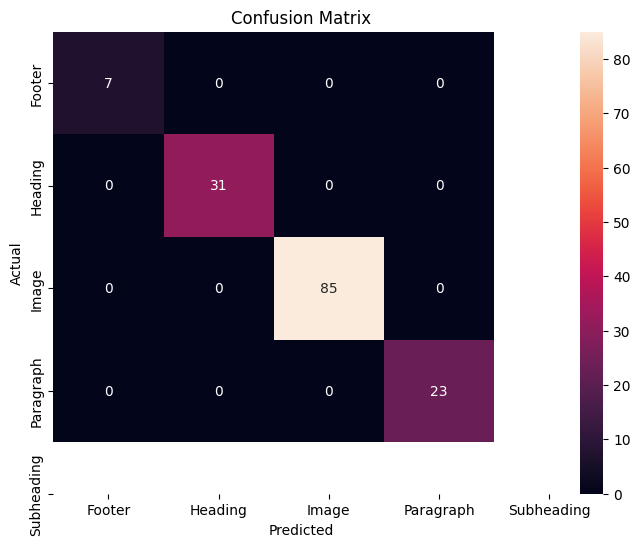


---------------------------------------
          MODEL DIAGNOSIS
---------------------------------------
Training Accuracy: 0.9931
Testing Accuracy:  1.0000
=> Diagnosis: Model is generalizing well!

Running 5-Fold Cross-Validation on Training Data...


/home/ocs-22/Documents/pdf-structure-analyze-model/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


CV F1 Scores for each fold: [0.9236 0.9791 0.9915 1.     0.9261]
Average CV F1: 0.9640
Score Variance (+/-): 0.0654
=> Diagnosis: Low variance. Model is stable.


In [6]:
print("\n---------------------------------------")
print("        FINAL TEST PERFORMANCE")
print("---------------------------------------")

# Predictions
y_pred = best_model.predict(X_test)

# 1️⃣ Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# 2️⃣ Detailed Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 3️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\n---------------------------------------")
print("          MODEL DIAGNOSIS")
print("---------------------------------------")

# 4️⃣ Compare Training vs Testing Accuracy (Overfitting Check)
y_train_pred = best_model.predict(X_train)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy:  {test_acc:.4f}")

if (train_acc - test_acc) > 0.05:
    print("=> Diagnosis: Model might be OVERFITTING.")
elif train_acc < 0.60:
    print("=> Diagnosis: Model might be UNDERFITTING.")
else:
    print("=> Diagnosis: Model is generalizing well!")

# 5️⃣ Cross Validation
print("\nRunning 5-Fold Cross-Validation on Training Data...")

cv_scores = cross_val_score(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

print(f"CV F1 Scores for each fold: {np.round(cv_scores, 4)}")
print(f"Average CV F1: {cv_scores.mean():.4f}")
print(f"Score Variance (+/-): {cv_scores.std() * 2:.4f}")

if cv_scores.std() > 0.05:
    print("=> Diagnosis: High variance across folds.")
else:
    print("=> Diagnosis: Low variance. Model is stable.")

In [9]:
# ---------------------------------------
# Save Model
# ---------------------------------------

BASE_DIR = Path().resolve().parent.parent
MODEL_PATH = BASE_DIR / "models"
MODEL_PATH.mkdir(parents=True, exist_ok=True)

joblib.dump(best_model, MODEL_PATH / "pdf_structure_analyze_model.pkl")

print("\nModel saved successfully.")


Model saved successfully.
